## Creating and tuning a tf-idf model with a classifier
    -In this notebook we will create the tf-idf model and tune it
    - We will start with the data frame that has partially processed text, we will process it further.

In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(
    module='sklearn',
    action='ignore',
    message='Precision and')

In [4]:
lectures = pd.read_csv('all_lecture_text.csv')

In [3]:
lectures = pd.DataFrame()
# read data from text files
with open('sentences2.txt', 'r') as f:
    sentences = f.read()
with open('labels.txt', 'r') as f:
    labels = f.read()

In [5]:
lectures['sentences'] = sentences
lectures['labels'] = labels
lectures.head()

,sentences,labels


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 25
                             stop_words='english', #use english stopwords
                             lowercase=True, #lowercase
                             use_idf=True, #idf
                             norm=u'l2',  #normalization
                             smooth_idf=True)#add 1 to all words to prevent 0 division

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV

## Split the data and run initial Logistic Regression

In [7]:
X = lectures.d2v_text
y = lectures.Subject

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.30,random_state=43)

In [8]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((602,), (258,), (602,), (258,))

In [11]:
#vectorize the data
X_idf_train = vectorizer.fit_transform(X_train)
X_idf_test = vectorizer.transform(X_test)

In [70]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression(C=100,multi_class='multinomial',solver='lbfgs',n_jobs=12)

In [71]:
lrc.fit(X_idf_train,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=12, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
y_pred = lrc.predict(X_idf_test)

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [74]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

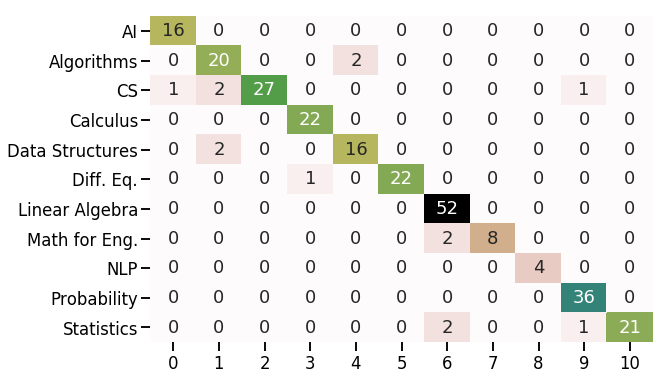

                 precision    recall  f1-score   support

             AI       0.94      1.00      0.97        16
     Algorithms       0.83      0.91      0.87        22
             CS       1.00      0.87      0.93        31
       Calculus       0.96      1.00      0.98        22
Data Structures       0.89      0.89      0.89        18
      Diff. Eq.       1.00      0.96      0.98        23
 Linear Algebra       0.93      1.00      0.96        52
  Math for Eng.       1.00      0.80      0.89        10
            NLP       1.00      1.00      1.00         4
    Probability       0.95      1.00      0.97        36
     Statistics       1.00      0.88      0.93        24

      micro avg       0.95      0.95      0.95       258
      macro avg       0.95      0.94      0.94       258
   weighted avg       0.95      0.95      0.95       258



In [75]:
heatconmat(y_test,y_pred)

## Custom grid search logistic regression
     -Here we iterate over possible values for min_df arg for the tf-idf vectorizer
     -then run a logistic regression over possible attribute inputs
     

In [130]:
cs = []
Classes = []
Penalties = []
Solvers = []
f1s = []
recalls = []
precs = []
min_word = []
min_df =[]
for number in range(8,25,2):
    vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                                 min_df=number, # only use words that appear at least 25
                                 stop_words='english', #use english stopwords
                                 lowercase=True, #lowercase
                                 use_idf=True, #idf
                                 norm=u'l2',  #normalization
                                 smooth_idf=True)#add 1 to all words to prevent 0 division

    X_idf_train = vectorizer.fit_transform(X_train)
    X_idf_test = vectorizer.transform(X_test)
    
    Cs = [1,2,5,8,13,15,17,20,25,30]
    multi_classes=['ovr','multinomial']
    penalties = ['l2']
    solvers = ['lbfgs','newton-cg','saga']


    for multi_class in multi_classes:
        for penalty in penalties:
            for solver in solvers:
                i = 1
                for C in Cs:
                    
                    lrc = LogisticRegression(C=C, class_weight=None, dual=False, fit_intercept=True,
                          intercept_scaling=1, max_iter=1000, multi_class=multi_class, n_jobs=8,
                          penalty=penalty, random_state=43, solver=solver, tol=0.0001,
                          verbose=0, warm_start=False)
                    lrc.fit(X_idf_train,y_train)
                    y_pred = lrc.predict(X_idf_test)
                    f1avg = classification_report(y_test,y_pred)[786:790]
                    recallavg = classification_report(y_test,y_pred)[776:779]
                    precavg = classification_report(y_test,y_pred)[766:770]
                    cs.append(C)
                    Classes.append(multi_class)
                    Penalties.append(penalty)
                    Solvers.append(solver)
                    f1s.append(f1avg)
                    recalls.append(recallavg)
                    precs.append(precavg)
                    min_df.append(number)
                    
                    if i%5 == 0:
                        print(i)
                        print(f1avg)

/home/extralime/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [131]:
import re
lrc_df = pd.DataFrame()
lrc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
lrc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
lrc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]
lrc_df['solver'] = Solvers
lrc_df['penalty'] = Penalties
lrc_df['class'] = Classes
lrc_df['C'] = cs
lrc_df['min_df'] = min_df
lrc_df.head()

,f1,recall,precision,solver,penalty,class,C,min_df
0,0.87,0.85,0.93,lbfgs,l2,ovr,1,8
1,0.88,0.86,0.92,lbfgs,l2,ovr,2,8
2,0.92,0.91,0.95,lbfgs,l2,ovr,5,8
3,0.92,0.91,0.95,lbfgs,l2,ovr,8,8
4,0.94,0.93,0.95,lbfgs,l2,ovr,13,8


In [132]:
lrc_df.sort_values(by='f1',ascending=False).head()

,f1,recall,precision,solver,penalty,class,C,min_df
49,0.95,0.95,0.96,newton-cg,l2,multinomial,30,8
59,0.95,0.95,0.96,saga,l2,multinomial,30,8
39,0.95,0.95,0.96,lbfgs,l2,multinomial,30,8
96,0.94,0.93,0.95,lbfgs,l2,multinomial,17,10
229,0.94,0.94,0.95,newton-cg,l2,multinomial,30,14


In [133]:
lrc_df.to_csv('lrc_grid_tfidf.csv')

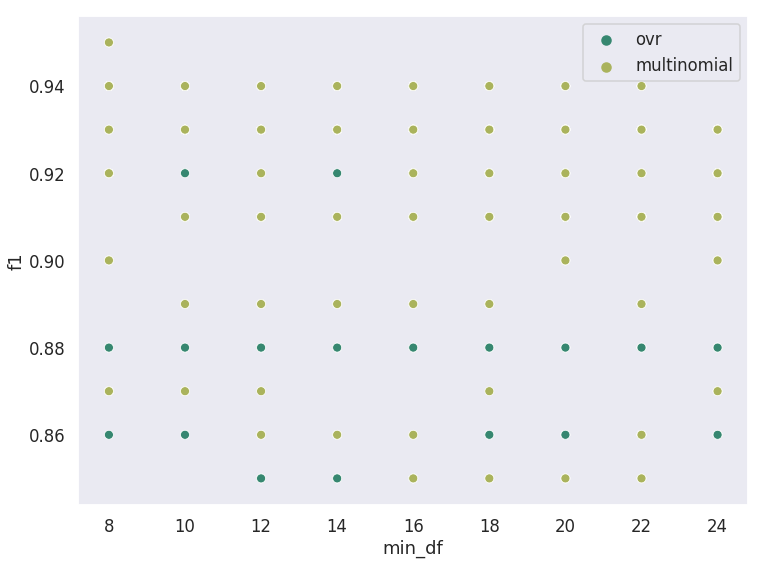

In [134]:
sns.set(style='dark',context='talk')
plt.figure(figsize=(12,9))
sns.scatterplot(x='min_df',y='f1', data=lrc_df,hue=Classes, palette='gist_earth')
plt.legend(bbox_to_anchor=[1,1])
plt.show()

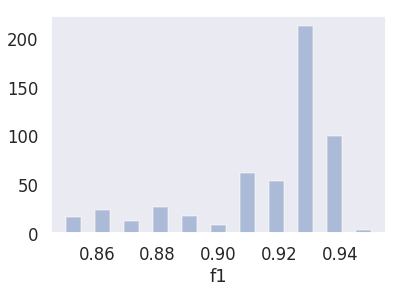

In [135]:
sns.distplot(lrc_df.f1, kde=False)

# Use best results from gridsearch

In [76]:
vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                                 min_df=18, # only use words that appear at least n
                                 stop_words='english', #use english stopwords
                                 lowercase=True, #lowercase
                                 use_idf=True, #idf
                                 norm=u'l2',  #normalization
                                 smooth_idf=True)#add 1 to all words to prevent 0 division

lrc = LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
                          intercept_scaling=1, max_iter=1000, multi_class='multinomial', n_jobs=12,
                          penalty='l2', random_state=43, solver='saga', tol=0.0001,
                          verbose=0, warm_start=False)

In [77]:
lrc.fit(X_idf_train,y_train)

LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=12, penalty='l2', random_state=43, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [78]:
y_pred = lrc.predict(X_idf_test)



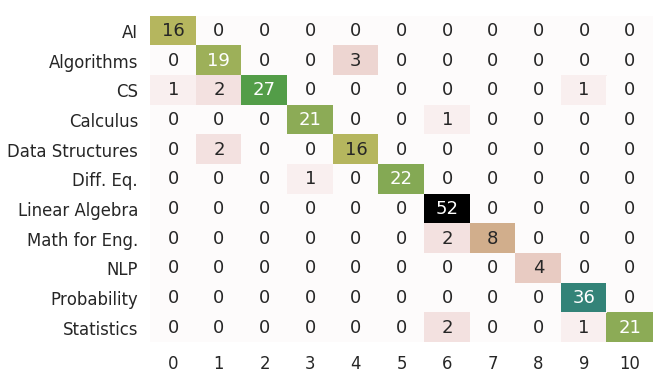

                 precision    recall  f1-score   support

             AI       0.94      1.00      0.97        16
     Algorithms       0.83      0.86      0.84        22
             CS       1.00      0.87      0.93        31
       Calculus       0.95      0.95      0.95        22
Data Structures       0.84      0.89      0.86        18
      Diff. Eq.       1.00      0.96      0.98        23
 Linear Algebra       0.91      1.00      0.95        52
  Math for Eng.       1.00      0.80      0.89        10
            NLP       1.00      1.00      1.00         4
    Probability       0.95      1.00      0.97        36
     Statistics       1.00      0.88      0.93        24

      micro avg       0.94      0.94      0.94       258
      macro avg       0.95      0.93      0.94       258
   weighted avg       0.94      0.94      0.94       258



In [79]:
heatconmat(y_test,y_pred)

In [65]:
# Cross Validation

In [66]:
from sklearn.model_selection import cross_val_score

In [67]:
vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                                 min_df=24, # only use words that appear at least 25
                                 stop_words='english', #use english stopwords
                                 lowercase=True, #lowercase
                                 use_idf=True, #idf
                                 norm=u'l2',  #normalization
                                 smooth_idf=True)#add 1 to all words to prevent 0 division

In [68]:
X_idf = vectorizer.fit_transform(X)

In [69]:
pd.DataFrame(X_idf.todense()).to_csv('X_idf.csv',index=False)
y.to_csv('y_idf.csv',index=False)

/home/extralime/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [70]:
cvscors = cross_val_score(lrc,X_idf.todense(),y,cv=5)
cv_mean = cvscors.mean()
cv_std = cvscors.std()
cv_mean,cv_std

(0.9501165825997127, 0.011445335576228018)

In [74]:
X = X_idf.todense()
cv_stds = []
cv_means = []
for i in range(2,17,1):
    cvscors = cross_val_score(lrc,X,y,cv=i)
    cv_means.append(cvscors.mean())
    cv_stds.append(cvscors.std())
    cv_mean,cv_std

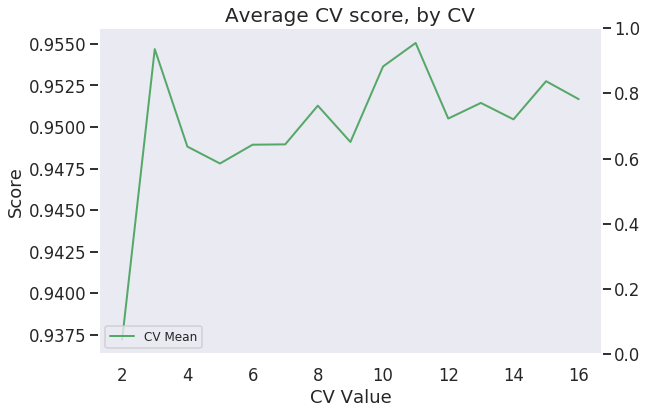

In [75]:
sns.set(context='talk', style='dark')
fig, ax = fig, ax = plt.subplots(figsize=(9,6))

ax2 = ax.twinx()
ax = sns.lineplot(range(2,17,1), cv_means,color='g', label='CV Mean', linewidth=2, ax=ax)
#ax2 =sns.lineplot(range(2,15,1), favgobs,color='purple',label='Avg obs per cluster', linewidth=2)
#sns.lineplot(range(2,17,1),fobsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
#sns.lineplot(range(2,17,1),fstdneg,color='r', linewidth=.6)

ax.set_ylabel('Score')
ax.set_xlabel('CV Value')
#ax.axvline(x=range(2,17,1)[np.argmax(cv_means)],color='r',linestyle='dotted')


ax.legend(loc='lower left',prop={'size': 12})
#ax2.legend(loc='center right',prop={'size': 12})
#plt.ylabel('Score')
#plt.xlabel('CV value')
plt.title('Average CV score, by CV',fontsize=20)
plt.show()

In [146]:
cv_mean = cvscors.mean()
cv_std = cvscors.std()
cv_mean,cv_std

(0.9478037483751137, 0.010459377929521747)

In [147]:
cv_mean,cv_std

(0.9478037483751137, 0.010459377929521747)

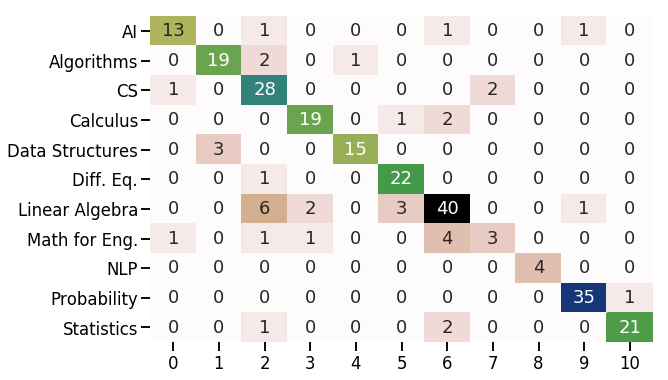

                 precision    recall  f1-score   support

             AI       0.87      0.81      0.84        16
     Algorithms       0.86      0.86      0.86        22
             CS       0.70      0.90      0.79        31
       Calculus       0.86      0.86      0.86        22
Data Structures       0.94      0.83      0.88        18
      Diff. Eq.       0.85      0.96      0.90        23
 Linear Algebra       0.82      0.77      0.79        52
  Math for Eng.       0.60      0.30      0.40        10
            NLP       1.00      1.00      1.00         4
    Probability       0.95      0.97      0.96        36
     Statistics       0.95      0.88      0.91        24

      micro avg       0.85      0.85      0.85       258
      macro avg       0.85      0.83      0.84       258
   weighted avg       0.85      0.85      0.85       258



In [19]:
gbc = GradientBoostingClassifier(n_estimators=15, min_samples_split=3, 
                            min_samples_leaf=4, max_depth=5, random_state=43)                    
gbc.fit(X_idf_train,y_train)
y_pred = gbc.predict(X_idf_test)
heatconmat(y_test,y_pred)

# SVC

In [148]:
from sklearn.svm import SVC

svc = SVC(C=10,decision_function_shape='multinomial', kernel='linear')
svc.fit(X_idf_train,y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='multinomial', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [149]:
y_pred = svc.predict(X_idf_test)

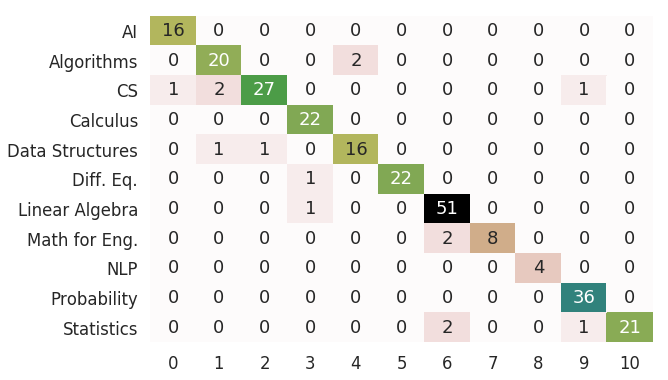

                 precision    recall  f1-score   support

             AI       0.94      1.00      0.97        16
     Algorithms       0.87      0.91      0.89        22
             CS       0.96      0.87      0.92        31
       Calculus       0.92      1.00      0.96        22
Data Structures       0.89      0.89      0.89        18
      Diff. Eq.       1.00      0.96      0.98        23
 Linear Algebra       0.93      0.98      0.95        52
  Math for Eng.       1.00      0.80      0.89        10
            NLP       1.00      1.00      1.00         4
    Probability       0.95      1.00      0.97        36
     Statistics       1.00      0.88      0.93        24

      micro avg       0.94      0.94      0.94       258
      macro avg       0.95      0.93      0.94       258
   weighted avg       0.94      0.94      0.94       258



In [150]:
heatconmat(y_test,y_pred)

In [151]:
cs = []
kernels = []
shapes = []

f1s = []
recalls = []
precs = []

min_df =[]
for number in range(8,25,2):
    vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                                 min_df=number, # only use words that appear at least 25
                                 stop_words='english', #use english stopwords
                                 lowercase=True, #lowercase
                                 use_idf=True, #idf
                                 norm=u'l2',  #normalization
                                 smooth_idf=True)#add 1 to all words to prevent 0 division

    X_idf_train = vectorizer.fit_transform(X_train)
    X_idf_test = vectorizer.transform(X_test)
    
    Cs = [1,2,5,8,13,15,17,20,25,30]
    df_shape=['ovr','multinomial']
    kernel = ['linear','poly']


    for kern in kernel:
        for shape in df_shape:
            
                i = 1
                for C in Cs:
                    
                    svc = SVC(C=C, decision_function_shape=shape, max_iter=-1, kernel=kern,random_state=43, 
                              tol=0.0001)
                    svc.fit(X_idf_train,y_train)
                    y_pred = svc.predict(X_idf_test)
                    f1avg = classification_report(y_test,y_pred)[786:790]
                    recallavg = classification_report(y_test,y_pred)[776:779]
                    precavg = classification_report(y_test,y_pred)[766:770]
                    cs.append(C)
                    kernels.append(kern)
                    shapes.append(shape)
                    
                    f1s.append(f1avg)
                    recalls.append(recallavg)
                    precs.append(precavg)
                    min_df.append(number)
                    
                    

/home/extralime/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [152]:
svc_df = pd.DataFrame()
svc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
svc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
svc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]

svc_df['kernel'] = kernels
svc_df['df_shape'] = shapes
svc_df['C'] = cs
svc_df['min_df'] = min_df
svc_df.head()

,f1,recall,precision,kernel,df_shape,C,min_df
0,0.92,0.91,0.94,linear,ovr,1,8
1,0.95,0.94,0.95,linear,ovr,2,8
2,0.95,0.94,0.95,linear,ovr,5,8
3,0.95,0.94,0.95,linear,ovr,8,8
4,0.95,0.94,0.95,linear,ovr,13,8


In [153]:
svc_df.sort_values(by='f1',ascending=False)[:5]

,f1,recall,precision,kernel,df_shape,C,min_df
241,0.95,0.94,0.96,linear,ovr,2,20
219,0.95,0.95,0.96,linear,multinomial,30,18
52,0.95,0.95,0.95,linear,multinomial,5,10
212,0.95,0.95,0.96,linear,multinomial,5,18
213,0.95,0.95,0.96,linear,multinomial,8,18


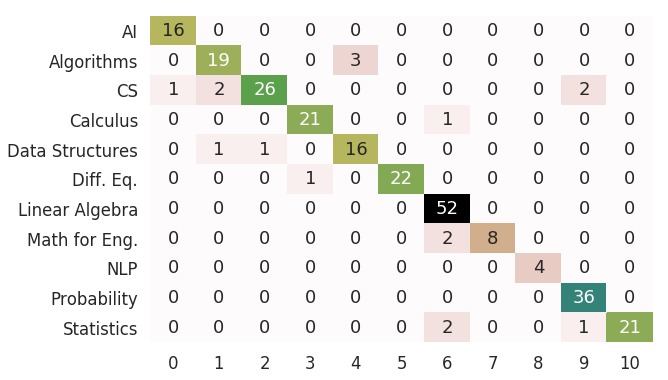

                 precision    recall  f1-score   support

             AI       0.94      1.00      0.97        16
     Algorithms       0.86      0.86      0.86        22
             CS       0.96      0.84      0.90        31
       Calculus       0.95      0.95      0.95        22
Data Structures       0.84      0.89      0.86        18
      Diff. Eq.       1.00      0.96      0.98        23
 Linear Algebra       0.91      1.00      0.95        52
  Math for Eng.       1.00      0.80      0.89        10
            NLP       1.00      1.00      1.00         4
    Probability       0.92      1.00      0.96        36
     Statistics       1.00      0.88      0.93        24

      micro avg       0.93      0.93      0.93       258
      macro avg       0.95      0.93      0.93       258
   weighted avg       0.94      0.93      0.93       258



In [154]:
vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                                 min_df=20, # only use words that appear at least 25
                                 stop_words='english', #use english stopwords
                                 lowercase=True, #lowercase
                                 use_idf=True, #idf
                                 norm=u'l2',  #normalization
                                 smooth_idf=True)#add 1 to all words to prevent 0 division
svc  = SVC(kernel='linear', decision_function_shape='ovr',C=2)
svc.fit(X_idf_train,y_train)
y_pred = svc.predict(X_idf_test)
heatconmat(y_test,y_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
estims = []
mds = []
msls = []
msss = []
crit = []

f1s = []
recalls = []
precs = []

n_estimators = range(100,1000,200)
max_depths = [2,4,6,7,9,12]
msl = [2,3,4,5]
mss = [2,3,4,5]
criterion = ['gini','entropy']

for cri in criterion:
    for n_ests in n_estimators:
        for md in max_depths:
            for ml in msl:
                for ms in mss:          

                    rfc = RandomForestClassifier(criterion=cri,max_depth=md,
                                min_samples_leaf=ml, min_samples_split=ms,
                                min_weight_fraction_leaf=0.0, n_estimators=n_ests, n_jobs=12,
                                random_state=43)                                
                    rfc.fit(X_idf_train,y_train)
                    y_pred = rfc.predict(X_idf_test)
                    f1avg = classification_report(y_test,y_pred)[786:790]
                    recallavg = classification_report(y_test,y_pred)[776:779]
                    precavg = classification_report(y_test,y_pred)[766:770]
                    estims.append(n_ests)
                    mds.append(md)
                    msls.append(ml)
                    msss.append(ms)
                    crit.append(cri)
                    
                    f1s.append(f1avg)
                    recalls.append(recallavg)
                    precs.append(precavg)

In [ ]:
rfc_df = pd.DataFrame()
rfc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
rfc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
rfc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]
rfc_df['n_ests'] = estims
rfc_df['max_depths'] = mds
rfc_df['min_leaf'] = msls
rfc_df['min_split'] = msss
rfc_df['ctriteron'] = crit
rfc_df.sort_values(by='f1',ascending=False)

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
estims = []
mds = []
msls = []
msss = []


f1s = []
recalls = []
precs = []

n_estimators = range(300,1000,200)
max_depths = [6,7,9]
msl = [3,4,5]
mss = [2,3,5]



for n_ests in n_estimators:
    for md in max_depths:
        for ml in msl:
            for ms in mss:          

                gbc = GradientBoostingClassifier(n_estimators=n_ests, min_samples_split=ms, 
                            min_samples_leaf=ml, max_depth=md, random_state=43)                    
                gbc.fit(X_idf_train,y_train)
                y_pred = gbc.predict(X_idf_test)
                f1avg = classification_report(y_test,y_pred)[786:790]
                recallavg = classification_report(y_test,y_pred)[776:779]
                precavg = classification_report(y_test,y_pred)[766:770]
                estims.append(n_ests)
                mds.append(md)
                msls.append(ml)
                msss.append(ms)
                

                f1s.append(f1avg)
                recalls.append(recallavg)
                precs.append(precavg)

In [36]:
import re
gbc_df = pd.DataFrame()
gbc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
gbc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
gbc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]
gbc_df['n_ests'] = estims
gbc_df['max_depths'] = mds
gbc_df['min_leaf'] = msls
gbc_df['min_split'] = msss

gbc_df.sort_values(by='f1',ascending=False)

,f1,recall,precision,n_ests,max_depths,min_leaf,min_split
33,0.90,0.89,0.91,500,6,5,2
17,0.90,0.89,0.92,300,7,5,5
62,0.90,0.89,0.91,700,6,5,5
61,0.90,0.89,0.91,700,6,5,3
60,0.90,0.89,0.91,700,6,5,2
70,0.90,0.89,0.92,700,7,5,3
71,0.90,0.89,0.92,700,7,5,5
44,0.90,0.89,0.92,500,7,5,5
43,0.90,0.89,0.92,500,7,5,3
42,0.90,0.89,0.92,500,7,5,2


In [ ]:
gbc_df.sort_values(by='f1',ascending=False)

# Using POS tagging

In [262]:
#use the non normed pos_df to model
#non normal works well with randomforest
pos_df = pd.read_csv('non_norm_pos.csv')

In [263]:
X,y = pos_df,lectures.Subject

In [264]:
X_all = pd.concat([pd.DataFrame(X_idf),pos_df],axis=1)
X_all_train,X_all_test,y_train,y_test = train_test_split(X_all,y,test_size=.3, random_state=43)

In [253]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=400,max_depth=9,min_samples_split=2,criterion='entropy')

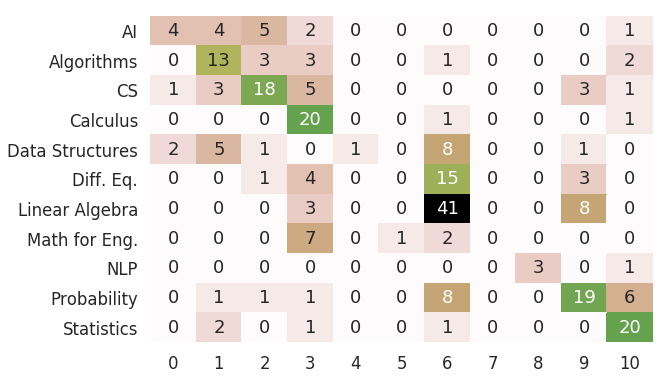

                 precision    recall  f1-score   support

             AI       0.57      0.25      0.35        16
     Algorithms       0.46      0.59      0.52        22
             CS       0.62      0.58      0.60        31
       Calculus       0.43      0.91      0.59        22
Data Structures       1.00      0.06      0.11        18
      Diff. Eq.       0.00      0.00      0.00        23
 Linear Algebra       0.53      0.79      0.64        52
  Math for Eng.       0.00      0.00      0.00        10
            NLP       1.00      0.75      0.86         4
    Probability       0.56      0.53      0.54        36
     Statistics       0.62      0.83      0.71        24

      micro avg       0.54      0.54      0.54       258
      macro avg       0.53      0.48      0.45       258
   weighted avg       0.52      0.54      0.48       258



In [254]:
rfc.fit(X_all_train,y_train)
y_pred = rfc.predict(X_all_test)
heatconmat(y_test,y_pred)

In [ ]:
#normalized data works better with the logistic regression

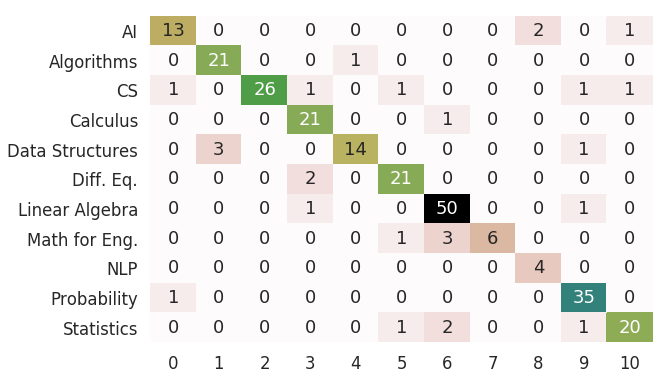

                 precision    recall  f1-score   support

             AI       0.87      0.81      0.84        16
     Algorithms       0.88      0.95      0.91        22
             CS       1.00      0.84      0.91        31
       Calculus       0.84      0.95      0.89        22
Data Structures       0.93      0.78      0.85        18
      Diff. Eq.       0.88      0.91      0.89        23
 Linear Algebra       0.89      0.96      0.93        52
  Math for Eng.       1.00      0.60      0.75        10
            NLP       0.67      1.00      0.80         4
    Probability       0.90      0.97      0.93        36
     Statistics       0.91      0.83      0.87        24

      micro avg       0.90      0.90      0.90       258
      macro avg       0.89      0.87      0.87       258
   weighted avg       0.90      0.90      0.89       258



In [228]:
lrc = LogisticRegression(C=16, multi_class='multinomial',n_jobs=10,
                         penalty='l1', random_state=43, solver='saga',max_iter=2000)
lrc.fit(X_all_train,y_train)
y_pred = lrc.predict(X_all_test)
heatconmat(y_test,y_pred)

In [ ]:
cs = []
Classes = []
Penalties = []
Solvers = []
f1s = []
recalls = []
precs = []
min_word = []
min_df =[]
for number in range(8,25,2):
    vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                                 min_df=number, # only use words that appear at least 25
                                 stop_words='english', #use english stopwords
                                 lowercase=True, #lowercase
                                 use_idf=True, #idf
                                 norm=u'l2',  #normalization
                                 smooth_idf=True)#add 1 to all words to prevent 0 division

    X_idf_train = vectorizer.fit_transform(X_train)
    X_idf_test = vectorizer.transform(X_test)
    
    Cs = [1,2,5,8,13,15,17,20,25,30]
    multi_classes=['ovr','multinomial']
    penalties = ['l2']
    solvers = ['lbfgs','newton-cg','saga']


    for multi_class in multi_classes:
        for penalty in penalties:
            for solver in solvers:
                i = 1
                for C in Cs:
                    
                    lrc = LogisticRegression(C=C, class_weight=None, dual=False, fit_intercept=True,
                          intercept_scaling=1, max_iter=1000, multi_class=multi_class, n_jobs=8,
                          penalty=penalty, random_state=43, solver=solver, tol=0.0001,
                          verbose=0, warm_start=False)
                    lrc.fit(X_idf_train,y_train)
                    y_pred = lrc.predict(X_idf_test)
                    f1avg = classification_report(y_test,y_pred)[786:790]
                    recallavg = classification_report(y_test,y_pred)[776:779]
                    precavg = classification_report(y_test,y_pred)[766:770]
                    cs.append(C)
                    Classes.append(multi_class)
                    Penalties.append(penalty)
                    Solvers.append(solver)
                    f1s.append(f1avg)
                    recalls.append(recallavg)
                    precs.append(precavg)
                    min_df.append(number)

In [230]:
from sklearn.ensemble import GradientBoostingClassifier

In [9]:
gbc = GradientBoostingClassifier(n_estimators=700, min_samples_split=3, 
                            min_samples_leaf=4, max_depth=7, random_state=43)                    
gbc.fit(X_all_train,y_train)
y_pred = gbc.predict(X_all_test)
heatconmat(y_test,y_pred)

NameError: name 'X_all_train' is not defined

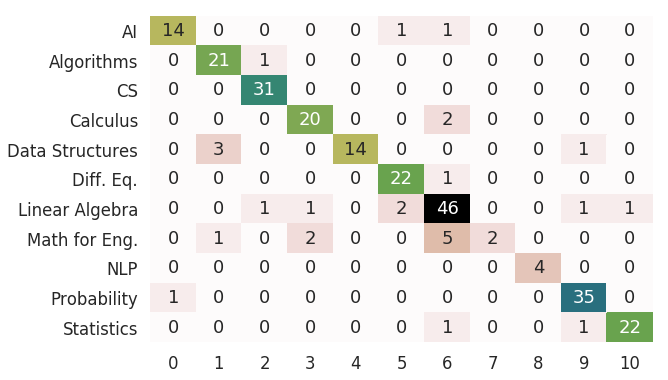

                 precision    recall  f1-score   support

             AI       0.93      0.88      0.90        16
     Algorithms       0.84      0.95      0.89        22
             CS       0.94      1.00      0.97        31
       Calculus       0.87      0.91      0.89        22
Data Structures       1.00      0.78      0.88        18
      Diff. Eq.       0.88      0.96      0.92        23
 Linear Algebra       0.82      0.88      0.85        52
  Math for Eng.       1.00      0.20      0.33        10
            NLP       1.00      1.00      1.00         4
    Probability       0.92      0.97      0.95        36
     Statistics       0.96      0.92      0.94        24

      micro avg       0.90      0.90      0.90       258
      macro avg       0.92      0.86      0.86       258
   weighted avg       0.90      0.90      0.89       258



In [234]:
y_pred = gbc.predict(X_all_test)
heatconmat(y_test,y_pred)

In [238]:
estims = []
mds = []
msls = []
msss = []
crit = []

f1s = []
recalls = []
precs = []
min_df=[]
    
    
for number in range(8,25,2):
    vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                                 min_df=number, # only use words that appear at least 25
                                 stop_words='english', #use english stopwords
                                 lowercase=True, #lowercase
                                 use_idf=True, #idf
                                 norm=u'l2',  #normalization
                                 smooth_idf=True)#add 1 to all words to prevent 0 division
    

    X_idf_train = vectorizer.fit_transform(X_train)
    X_idf_test = vectorizer.transform(X_test)
    X_idf = np.concatenate([X_idf_train.todense(),X_idf_test.todense()],axis=0)
    
    X_all = pd.concat([pd.DataFrame(X_idf),pos_df],axis=1)
    X_all_train,X_all_test,y_train,y_test = train_test_split(X_all,y,test_size=.3, random_state=43)
    
    n_estimators = range(100,1000,200)
    max_depths = [2,4,6,7,9,12]
    msl = [2,3,4,5]
    mss = [2,3,4,5]
    criterion = ['gini','entropy']

    for cri in criterion:
        for n_ests in n_estimators:
            for md in max_depths:
                for ml in msl:
                    for ms in mss:          

                        rfc = RandomForestClassifier(criterion=cri,max_depth=md,
                                    min_samples_leaf=ml, min_samples_split=ms,
                                    min_weight_fraction_leaf=0.0, n_estimators=n_ests, n_jobs=12,
                                    random_state=43)                                
                        rfc.fit(X_all_train,y_train)
                        y_pred = rfc.predict(X_all_test)
                        f1avg = classification_report(y_test,y_pred)[786:790]
                        recallavg = classification_report(y_test,y_pred)[776:779]
                        precavg = classification_report(y_test,y_pred)[766:770]
                        estims.append(n_ests)
                        mds.append(md)
                        msls.append(ml)
                        msss.append(ms)
                        crit.append(cri)

                        f1s.append(f1avg)
                        recalls.append(recallavg)
                        precs.append(precavg)
                        min_df.append(number)

In [239]:
rfc_df = pd.DataFrame()
rfc_df['f1']= [float(re.sub('\s*','',i)) for i in f1s]
rfc_df['recall'] = [float(re.sub('\s*','',i)) for i in recalls]
rfc_df['precision'] = [float(re.sub('\s*','',i)) for i in precs]
rfc_df['n_ests'] = estims
rfc_df['max_depths'] = mds
rfc_df['min_leaf'] = msls
rfc_df['min_split'] = msss
rfc_df['ctriteron'] = crit
rfc_df['min_df'] = min_df
rfc_df.sort_values(by='f1',ascending=False)

,f1,recall,precision,n_ests,max_depths,min_leaf,min_split,ctriteron,min_df
8342,0.56,0.53,0.72,300,12,3,4,entropy,24
8343,0.56,0.53,0.72,300,12,3,5,entropy,24
8340,0.56,0.53,0.72,300,12,3,2,entropy,24
8435,0.56,0.54,0.73,500,12,2,5,entropy,24
4691,0.56,0.53,0.73,700,12,2,5,entropy,16
8341,0.56,0.53,0.72,300,12,3,3,entropy,24
8627,0.55,0.53,0.72,900,12,2,5,entropy,24
4787,0.55,0.52,0.72,900,12,2,5,entropy,16
8624,0.55,0.53,0.72,900,12,2,2,entropy,24
7671,0.55,0.53,0.72,900,12,3,5,entropy,22


In [266]:
X = lectures.d2v_text
y = lectures.Subject

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.30,random_state=17)

In [268]:
pos_df = pd.read_csv('non_norm_pos.csv')

In [271]:
vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                                 min_df=16, # only use words that appear at least 25
                                 stop_words='english', #use english stopwords
                                 lowercase=True, #lowercase
                                 use_idf=True, #idf
                                 norm=u'l2',  #normalization
                                 smooth_idf=True)#add 1 to all words to prevent 0 division

X_idf_train = vectorizer.fit_transform(X_train)
X_idf_test = vectorizer.transform(X_test)

X_idf_all = pd.DataFrame(np.concatenate([X_idf_train.todense(),X_idf_test.todense()],axis=0))

X_idf_pos = pd.concat([X_idf_all,pos_df],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X_idf_pos,y,test_size=.3,random_state=43)

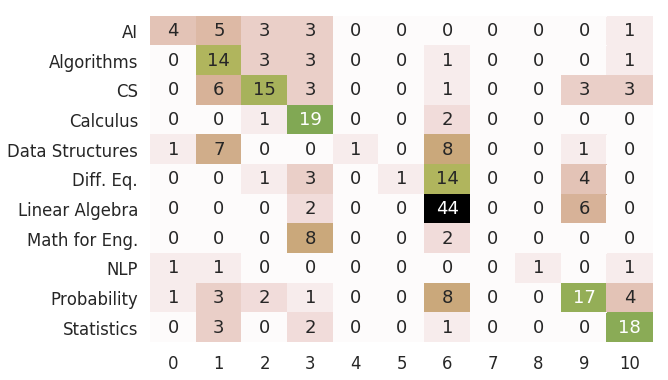

                 precision    recall  f1-score   support

             AI       0.57      0.25      0.35        16
     Algorithms       0.36      0.64      0.46        22
             CS       0.60      0.48      0.54        31
       Calculus       0.43      0.86      0.58        22
Data Structures       1.00      0.06      0.11        18
      Diff. Eq.       1.00      0.04      0.08        23
 Linear Algebra       0.54      0.85      0.66        52
  Math for Eng.       0.00      0.00      0.00        10
            NLP       1.00      0.25      0.40         4
    Probability       0.55      0.47      0.51        36
     Statistics       0.64      0.75      0.69        24

      micro avg       0.52      0.52      0.52       258
      macro avg       0.61      0.42      0.40       258
   weighted avg       0.60      0.52      0.46       258



In [273]:
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
heatconmat(y_test,y_pred)

In [ ]:
rfc.fit(X_all_train,y_train)
y_pred = rfc.predict(X_all_test)
heatconmat(y_test,y_pred)